# Building A Handwritten Digits Classifier

This task is to explore the effectiveness of deep, feedforward neural networks at classifying images.

The dataset is imported from the preloaded scikit-learn library using the load_digits() function which returns a copy of the hand-written digit dataset from UCI.

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.datasets import load_digits
from sklearn.neural_network import MLPClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
data = load_digits()

data.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [31]:
labels = pd.Series(data['target'])
df = pd.DataFrame(data['data'])

labels.head()

0    0
1    1
2    2
3    3
4    4
dtype: int64

In [32]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


Because dataframes are a tabular representation of data, each image is represented as a row of pixel values. To visualize an image from the dataframe, we need to reshape the image back to its original dimensions (8 x 8 pixels). To visualize the image, we need to reshape these pixel values back into the 8 by 8 and plot them on a coordinate grid.

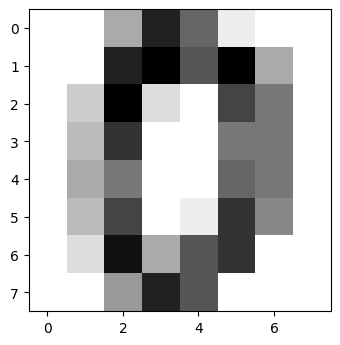

In [33]:
first_image = df.iloc[0]
np_image = first_image.values
np_image = np_image.reshape(8,8)

plt.imshow(np_image, cmap='gray_r')

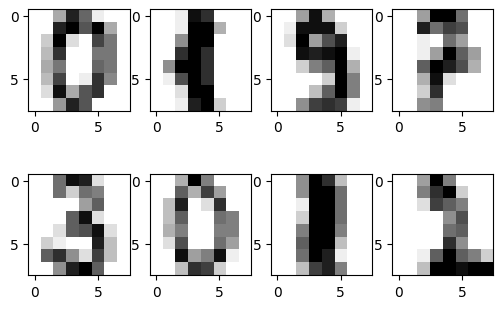

In [34]:
f, axarr = plt.subplots(2, 4)

axarr[0, 0].imshow(df.iloc[0].values.reshape(8,8), cmap='gray_r')
axarr[0, 1].imshow(df.iloc[99].values.reshape(8,8), cmap='gray_r')
axarr[0, 2].imshow(df.iloc[199].values.reshape(8,8), cmap='gray_r')
axarr[0, 3].imshow(df.iloc[299].values.reshape(8,8), cmap='gray_r')

axarr[1, 0].imshow(df.iloc[999].values.reshape(8,8), cmap='gray_r')
axarr[1, 1].imshow(df.iloc[1099].values.reshape(8,8), cmap='gray_r')
axarr[1, 2].imshow(df.iloc[1199].values.reshape(8,8), cmap='gray_r')
axarr[1, 3].imshow(df.iloc[1299].values.reshape(8,8), cmap='gray_r')

### Pipeline for testing and training k-nn models

While linear and logistic regression models make assumptions about the linearity between the features and the output labels, the k-nearest neighbors algorithm make no such assumption. This allows them to capture nonlinearity in the data. 

The k-nearest neighbors algorithm compares every unseen observation in the test set to all training observations to look for similar observations. Then, the algorithm finds the label with the most nearby observations and assigns that as the prediction for the unseen observation.

In [35]:
# 50% Train / test validation
def train(nneighbors, train_features, train_labels):
    knn = KNeighborsClassifier(n_neighbors = nneighbors)
    knn.fit(train_features, train_labels)
    return knn

def test(model, test_features, test_labels):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    overall_accuracy = sum(train_test_df["predicted_label"] == train_test_df["correct_label"])/len(train_test_df)    
    return overall_accuracy

def cross_validate(k):
    fold_accuracies = []
    kf = KFold(n_splits = 4, random_state=2, shuffle=True)
    for train_index, test_index in kf.split(df):
        train_features, test_features = df.loc[train_index], df.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        model = train(k, train_features, train_labels)
        overall_accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies
        
knn_one_accuracies = cross_validate(1)
np.mean(knn_one_accuracies)

0.9888728037614452

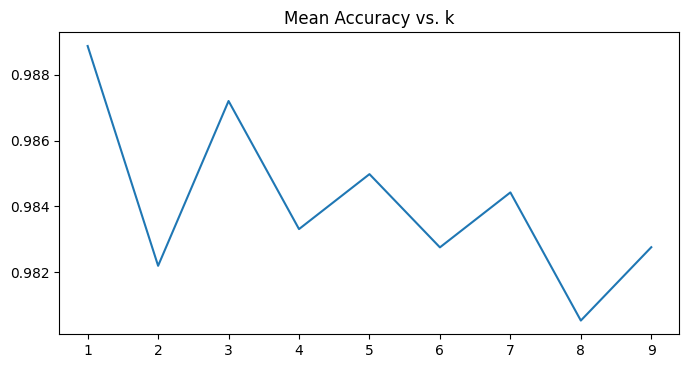

In [36]:
k_values = list(range(1,10)) # Checking for the knn model accuracy at different cross validation value
k_overall_accuracies = []

for k in k_values:
    k_accuracies = cross_validate(k)
    k_mean_accuracy = np.mean(k_accuracies)
    k_overall_accuracies.append(k_mean_accuracy)
    
plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. k")
plt.plot(k_values, k_overall_accuracies)

There are a few downsides to using k-nearest neighbors:

- high memory usage (for each new unseen observation, many comparisons need to be made to seen observations)
- no model representation to debug and explore

Let's now try a neural network with a single hidden layer. Use the MLPClassifier package from scikit-learn.

### Neural Network With One Hidden Layer

In [37]:
# 50% Train / test validation
def train(neuron_arch, train_features, train_labels):
    mlp = MLPClassifier(hidden_layer_sizes=neuron_arch)
    mlp.fit(train_features, train_labels)
    return mlp

def test(model, test_features, test_labels):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    overall_accuracy = sum(train_test_df["predicted_label"] == train_test_df["correct_label"])/len(train_test_df)    
    return overall_accuracy

def cross_validate(neuron_arch):
    fold_accuracies = []
    kf = KFold(n_splits = 4, random_state=2, shuffle=True)
    for train_index, test_index in kf.split(df):
        train_features, test_features = df.loc[train_index], df.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
       
        model = train(neuron_arch, train_features, train_labels)
        overall_accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural

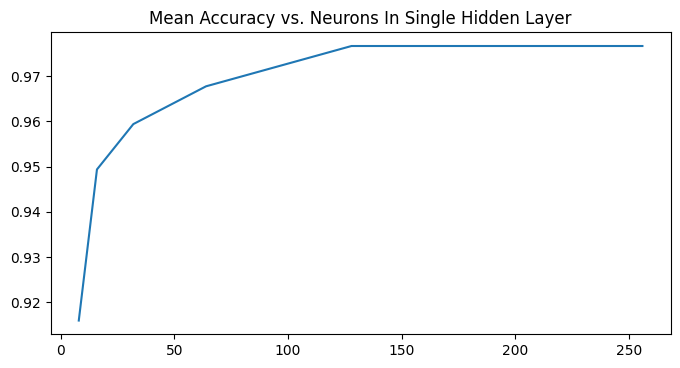

In [38]:
nn_one_neurons = [(8,), (16,), (32,), (64,), (128,), (256,)]
nn_one_accuracies = []

for n in nn_one_neurons:
    nn_accuracies = cross_validate(n)
    nn_mean_accuracy = np.mean(nn_accuracies)
    nn_one_accuracies.append(nn_mean_accuracy)

plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. Neurons In Single Hidden Layer")

x = [i[0] for i in nn_one_neurons]
plt.plot(x, nn_one_accuracies)

In [39]:
nn_one_accuracies

[0.9159762435040832,
 0.9493652561247216,
 0.9593801039346697,
 0.9677295223954466,
 0.9766344964117792,
 0.9766332590942836]

From the plot, adding more neurons to the single hidden layer improved simple accuracy to approximately 97%. Simple accuracy computes the number of correct classifications the model made, but doesn't tell us anything about false or true positives or false or true negatives.

Given that k-nearest neighbors achieved approximately 98% accuracy, there doesn't seem to be any advantages to using a single hidden layer neural network for this problem.

### Neural Network With Two Hidden Layers

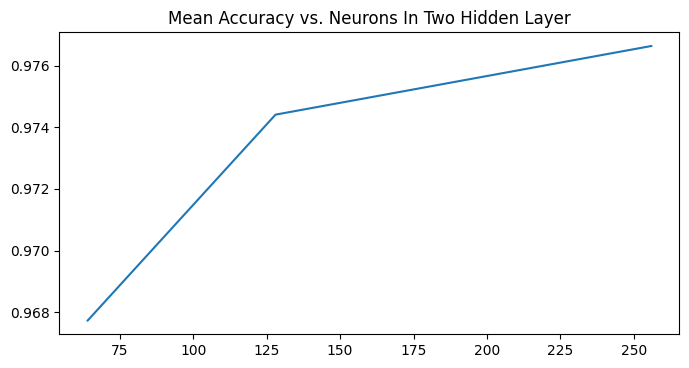

In [40]:
nn_two_neurons = [(64,64), (128,128), (256,256)]
nn_two_accuracies = []

for n in nn_two_neurons:
    nn_accuracies = cross_validate(n)
    nn_mean_accuracy = np.mean(nn_accuracies)
    nn_two_accuracies.append(nn_mean_accuracy)

plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. Neurons In Two Hidden Layer")

x = [i[0] for i in nn_two_neurons]
plt.plot(x, nn_two_accuracies)

In [41]:
nn_two_accuracies

[0.9677307597129423, 0.9744085622370701, 0.9766344964117792]

### Neural Network With Three Hidden Layers

In [42]:
# 50% Train / test validation
def train(neuron_arch, train_features, train_labels):
    mlp = MLPClassifier(hidden_layer_sizes=neuron_arch)
    mlp.fit(train_features, train_labels)
    return mlp

def test(model, test_features, test_labels):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    overall_accuracy = sum(train_test_df["predicted_label"] == train_test_df["correct_label"])/len(train_test_df)    
    return overall_accuracy

def cross_validate(neuron_arch):
    fold_accuracies = []
    kf = KFold(n_splits = 6, random_state=2, shuffle=True)
    for train_index, test_index in kf.split(df):
        train_features, test_features = df.loc[train_index], df.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
       
        model = train(neuron_arch, train_features, train_labels)
        overall_accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/neural

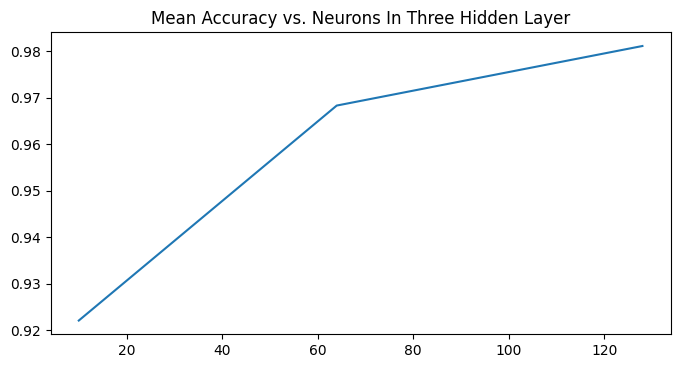

In [43]:
nn_three_neurons = [(10,10,10), (64,64,64), (128,128,128)]
nn_three_accuracies = []

for n in nn_three_neurons:
    nn_accuracies = cross_validate(n)
    nn_mean_accuracy = np.mean(nn_accuracies)
    nn_three_accuracies.append(nn_mean_accuracy)

plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. Neurons In Three Hidden Layer")

x = [i[0] for i in nn_three_neurons]
plt.plot(x, nn_three_accuracies)

In [44]:
nn_three_accuracies

[0.9220958751393534, 0.9682924563359346, 0.9810906726124117]

Using three hidden layers returned a simple accuracy of nearly 98%, even with six-fold cross validation.